In [1]:
import cv2
from common_methods import *
from google.cloud import vision
import numpy as np
from sklearn.cluster import AgglomerativeClustering

In [2]:
def get_words(resp):
    valid_words = []
    document = resp.full_text_annotation

    for page in document.pages:
        img_w = page.width
        img_h = page.height
        for block in page.blocks: 
            for para in block.paragraphs: 
                for word in para.words:
                    word = validate_word(word, img_w, img_h)
                    if word != None: valid_words.append(word)
    return valid_words

def validate_word(word, img_w, img_h):
    breaks = vision.TextAnnotation.DetectedBreak.BreakType
    line_break = [breaks.EOL_SURE_SPACE, breaks.LINE_BREAK, breaks.SURE_SPACE]
    word_break = [breaks.SPACE]
    hyphen_break = [breaks.HYPHEN]

    x1 = max(0,word.bounding_box.vertices[0].x)
    y1 = max(0,word.bounding_box.vertices[0].y)
    x2 = min(word.bounding_box.vertices[2].x, img_w)
    y2 = min(word.bounding_box.vertices[2].y, img_h)

    sbb = (x1, y1)
    ebb = (x2, y2)

    text = ''
    for symbol in word.symbols:
        text+=symbol.text
    if text == '': return None


    if word.symbols[-1].property.detected_break.type in line_break:
        break_type = 'line'
    elif word.symbols[-1].property.detected_break.type in word_break:
        break_type = 'word'
    elif word.symbols[-1].property.detected_break.type in hyphen_break:
        break_type = 'hyphen'
    else: break_type = 'none'

    return  {'text': text, 'sbb': sbb, 'ebb': ebb, 'break_type': break_type}

def centroid_clustering(centroids, points):
    clusters = []
    for p in points:
        clusters.append(np.absolute(np.array(centroids)-p).argmin())
    return clusters
        

def cluster_by_week(words):
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    centroids = {}
    points = []

    for word in words:
        x_coord = (word['sbb'][0] + word['ebb'][0])//2
        if word['text'] in week_days: centroids[word['text']] = x_coord
        points.append(x_coord)
    
    cluster_names = list(centroids.keys())
    centroids_values = list(centroids.values())

    cluster_assignment = centroid_clustering(centroids_values, points)

    clusters = []
    for i in range(len(cluster_names)):
        idx = np.where(np.array(cluster_assignment) == i)[0]
        # if len(idx) < 1: print("HOw?")
        # if len(idx) == 1: print(words[idx[0]]['text'])
        if len(idx)>1:
            cuur_cluster = []
            for j in idx: cuur_cluster.append(words[j])
            clusters.append(cuur_cluster)
    
    return cluster_names, clusters

def cluster_by_line(clusters):
    calendar = []
    for cluster in clusters:
        week = []
        merge_thresh = []
        points = []
        for word in cluster:
            merge_thresh.append(word['ebb'][1]-word['sbb'][1])
            points.append((word['sbb'][1],0))

        merge_thresh = np.mean(merge_thresh)//3

        clustering = AgglomerativeClustering( n_clusters=None, affinity="manhattan", 
                                        linkage="average", distance_threshold=merge_thresh)

        assignment = clustering.fit_predict(points)

        for l in np.unique(assignment):
            idx = np.where(assignment==l)[0]
            if len(idx)>0:
                row = []
                for i in idx:
                    row.append(cluster[i])
                row.sort(key=lambda x: x['sbb'][0])
                week.append(row)
        
        week.sort(key=lambda  x: x[0]['sbb'][1])
        calendar.append(parse_week(week))
    
    return calendar

def parse_week(week):
    text_l = []
    space_less_chars = ['-', ':']
    for row in week:
        for word in row:
            text_l.append(word['text'])
            if word['break_type']=='hyphen':
                text_l.append("-")
    
    text = ""
    prev_spaceless = True
    for t in text_l:

        if t in space_less_chars:
            c = t
            prev_spaceless = True
        else:
            if prev_spaceless: c = t
            else: c = " "+t
            prev_spaceless = False
        text+=c

    return text


In [11]:
data_path = 'data'
img, resp = load_img_resp(data_path, 'image_7.jpg')

In [12]:
words = get_words(resp)
cluster_names, clusters = cluster_by_week(words)
calendar = cluster_by_line(clusters)

In [13]:
calendar

['Tuesday ITSC 4155-001 24338 Class 8:30 am-11:15 am ONLINE INTERNET ITCS 3050-051 24587 Class 1:30 pm-3:30 pm ONLINE INTERNET ITCS 4152-001 22973 Class 5:30 pm-6:45 pm CHHS 155',
 'Wednesday ITCS 4111-001 24209 Class 2:30 pm-5:15 pm BIOIN 105',
 'Thursday ITCS 4152-001 22973 Class 5:30 pm-6:45 pm CHHS 155']

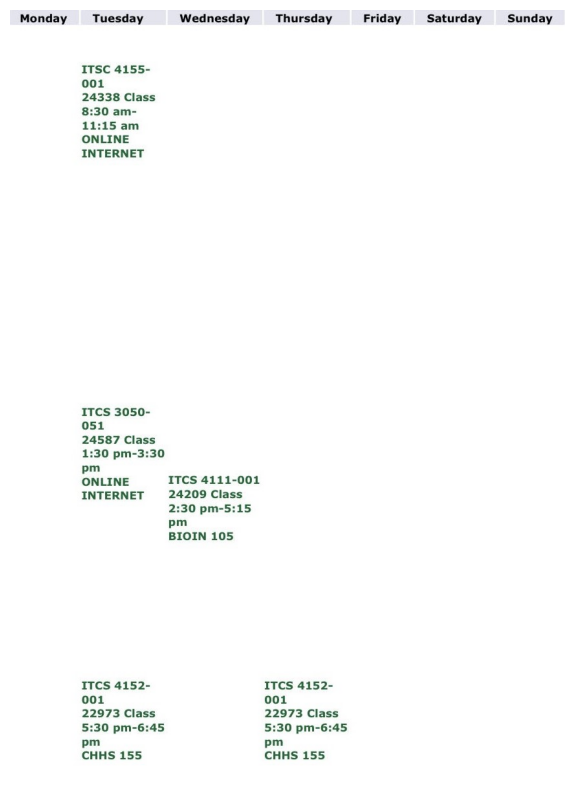

In [14]:
show_img(img, 10)